In [1]:
from billiard import *

In [2]:
QC = Billiard(shape='quartercircle', a1=1, a2=1, M0=400, V0=5e4)
QC.compute_everything()

V-matrix Imported


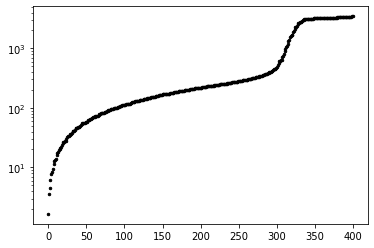

In [3]:
QC.plot_e_energies()

In [665]:
# area and perimeter
A  = np.pi/4
L = 2 + np.pi / 2

# multiply with area of billiard & use units like in paper
e_eigenvals = np.sort(eigenvals * A/(4*np.pi))

def weyl(E, A, L):
    return 1/(4*np.pi) * (A*E - L * np.sqrt(E))

def nE(Emax, E_list):
    # Returns count of entries in E_list smaller or equal to Emax
    count = 0
    for E in E_list:
        if E <= Emax:
            count += 1

    return count

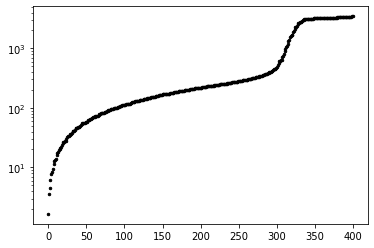

In [686]:
plt.scatter(range(len(e_eigenvals)), e_eigenvals, s=6, color="black")
plt.yscale("log")

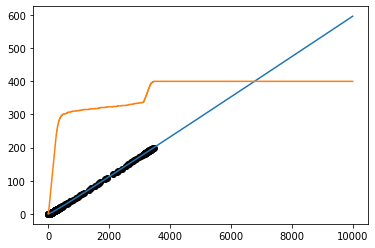

In [700]:

E_tilde = [weyl(E, A, L) for E in e_eigenvals]
plt.scatter(e_eigenvals, E_tilde, c="black")
plt.plot(range(10000), [weyl(i,A,L) for i in range(10000)])
plt.plot(range(10000), [nE(E, e_eigenvals) for E in range(10000)])
#plt.xlim([0,300])
#plt.ylim([-1,15])

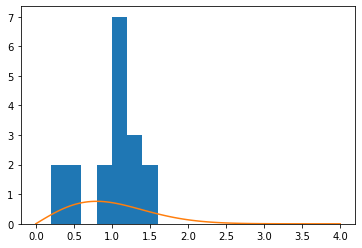

In [697]:
sn_tilde = [E_tilde[n+1] - E_tilde[n] for n in range(0, len(E_tilde)-1)]
sn = [(e_eigenvals[n+1] - e_eigenvals[n]) for n in range(0, len(e_eigenvals)-1)]

eigenvals = np.sort(eigenvals)
Ps = [min([eigenvals[i+1]- eigenvals[i], eigenvals[i] - eigenvals[i-1]]) for i in range(1,len(eigenvals) -1)]

mean = sum(Ps)/len(Ps)
plt.hist(np.sort(Ps), bins=[0, 0.2, 0.4, 0.6, 0.8, 1, 1.2, 1.4, 1.6, 1.8])

Pgoe = lambda s: np.pi/2 * s * np.exp(-np.pi * s**2 / 4)

S = np.linspace(0, 4, 100)

plt.plot(S, [Pgoe(s) for s in S])